In [8]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import interpolate

In [47]:
class BSpline(object):
  def __init__(self, knots: np.ndarray, control_points: np.ndarray, degree: int=3):
    """See also https://web.mit.edu/hyperbook/Patrikalakis-Maekawa-Cho/node17.html#fig:rep_cvx_hull_bspl
    """
    n = len(control_points)-1
    k = degree+1
    assert len(knots) == n+1+k
    self.n = n # 0->n control points
    self.k = k # k order, k-1 degree
    self.T = np.array(knots)
    self.p = np.array(control_points)
  
  def calcBasisFunction(self, t):
    """Calculate all basis function values in time t
    """
    N = np.zeros([self.n+1, self.k+1]) # basis function
    # order 1 is constant
    for i in range(self.n+1):
      N[i,1] = 1 if self.T[i]<=t<self.T[i+1] else 0
    
    # order k->k+1, see https://en.wikipedia.org/wiki/B-spline
    for k in range(1,self.k):
      for i in range(self.n+1):
        w_i_k = (t-self.T[i])/(self.T[i+k]-self.T[i]) if self.T[i+k]!=self.T[i] else 0
        w_i1_k = (t-self.T[i+1])/(self.T[i+1+k]-self.T[i+1]) if self.T[i+1+k]!=self.T[i+1] else 0
        if i<self.n:
          N[i,k+1] = w_i_k*N[i,k]+(1-w_i1_k)*N[i+1,k]
        else:
          N[i,k+1] = w_i_k*N[i,k]
    return N
  def DeBoor(self, t):
    # constrain t in [u_{k}, u_{n+1}]
    ub = min(max(self.T[self.k-1], t), self.T[-self.k])

    # determine which [ui,ui+1] lay in
    k = self.k-1
    while True:
      if self.T[k + 1] >= ub:
        break
      k+=1
    
    # deBoor's alg 
    c = self.p
    p = self.k-1
    x = ub
    t = self.T
    d = [c[j + k - p] for j in range(0, p + 1)]

    for r in range(1, p + 1):
        for j in range(p, r - 1, -1):
            alpha = (x - t[j + k - p]) / (t[j + 1 + k - r] - t[j + k - p])
            d[j] = (1.0 - alpha) * d[j - 1] + alpha * d[j]

    return d[p]

In [48]:
ctr =np.array( [(3 , 1), (2.5, 4), (0, 1), (-2.5, 4),
                (-3, 0), (-2.5, -4), (0, -1), (2.5, -4), (3, -1),])
x=ctr[:,0]
y=ctr[:,1]

# uncomment both lines for a closed curve
#x=np.append(x,[x[0]])  
#y=np.append(y,[y[0]])

l=len(x)  

t=np.linspace(0,1,l-2,endpoint=True)
t=np.append([0,0,0],t)
t=np.append(t,[1,1,1])
knots = t
print(t)
bs = BSpline(t, ctr, 3)


[0.         0.         0.         0.         0.16666667 0.33333333
 0.5        0.66666667 0.83333333 1.         1.         1.
 1.        ]


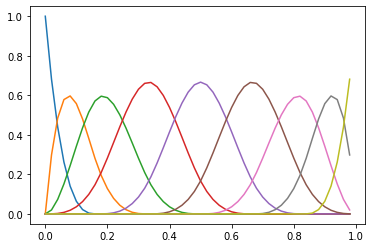

In [35]:
ts = np.linspace(0,1,endpoint=False)
basis_func_val = np.zeros([len(x), len(ts)])
for ind, t in enumerate(ts):
  basis_func_val[:,ind] = bs.calcBasisFunction(t)[:,-1]
for i in range(len(x)):
  plt.plot(ts, basis_func_val[i,:])

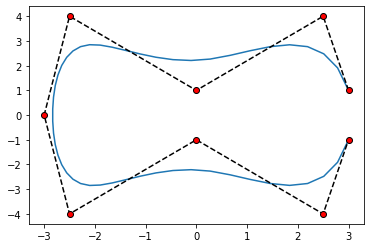

In [50]:

ts = np.linspace(0,1)
points = []
for t in ts:
  points.append(bs.DeBoor(t))
points = np.array(points)
plt.plot(points[:,0],points[:,1])
plt.plot(x,y,'k--',label='Control polygon',marker='o',markerfacecolor='red')
out = interpolate.splev(ts,[knots,[x,y],3])
# plt.plot(out[0],out[1],'b',linewidth=2.0,label='B-spline curve')

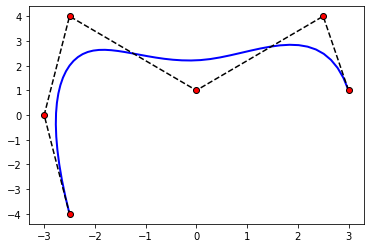

In [62]:
control_points = np.array([(3 , 1), (2.5, 4), (0, 1), (-2.5, 4),
                (-3, 0), (-2.5, -4)])
clamped_knots = [0, 0, 0, 0, 1/3, 2/3, 1, 1, 1, 1]
clamped_bspline = interpolate.splev(np.linspace(0,1),[clamped_knots,[control_points[:,0],control_points[:,1]],3])
plt.plot(clamped_bspline[0],clamped_bspline[1],'b',linewidth=2.0,label='B-spline curve')
plt.plot(control_points[:,0],control_points[:,1],'k--',label='Control polygon',marker='o',markerfacecolor='red')

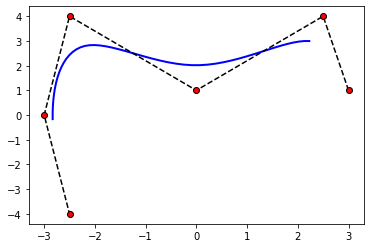

In [73]:
control_points = np.array([(3 , 1), (2.5, 4), (0, 1), (-2.5, 4),
                (-3, 0), (-2.5, -4)])
unclamped_knots = [-0.9, -0.6, -0.3, 0, 1/3, 2/3, 1, 1.3, 1.6, 1.9]
unclamped_bspline = interpolate.splev(np.linspace(0,1),[unclamped_knots,[control_points[:,0],control_points[:,1]],3])
plt.plot(unclamped_bspline[0],unclamped_bspline[1],'b',linewidth=2.0,label='B-spline curve')
plt.plot(control_points[:,0],control_points[:,1],'k--',label='Control polygon',marker='o',markerfacecolor='red')

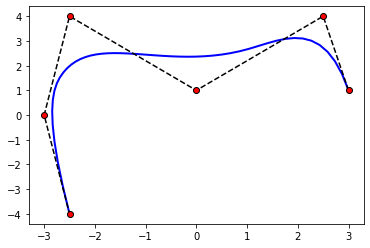

In [69]:
control_points = np.array([(3 , 1), (2.5, 4), (0, 1), (-2.5, 4),
                (-3, 0), (-2.5, -4)])
nonuniform_knots = [0, 0, 0, 0, 1/4, 4/5, 1, 1, 1, 1]
nonuniform_knots = interpolate.splev(np.linspace(0,1),[nonuniform_knots,[control_points[:,0],control_points[:,1]],3])
plt.plot(nonuniform_knots[0],nonuniform_knots[1],'b',linewidth=2.0,label='B-spline curve')
plt.plot(control_points[:,0],control_points[:,1],'k--',label='Control polygon',marker='o',markerfacecolor='red')

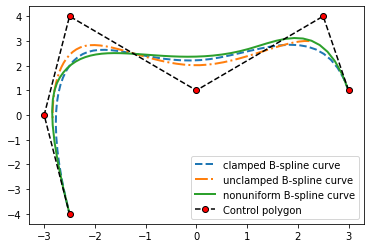

In [74]:
plt.plot(clamped_bspline[0],clamped_bspline[1],"--",linewidth=2.0,label='clamped B-spline curve')
plt.plot(unclamped_bspline[0],unclamped_bspline[1],"-.",linewidth=2.0,label='unclamped B-spline curve')
plt.plot(nonuniform_knots[0],nonuniform_knots[1],linewidth=2.0,label='nonuniform B-spline curve')
plt.plot(control_points[:,0],control_points[:,1],'k--',label='Control polygon',marker='o',markerfacecolor='red')
plt.legend()

In [105]:
from typing import List, Dict, Tuple
# https://hal.archives-ouvertes.fr/hal-03017566/document
def parameterizeToBspline(ts: float, point_set: List[List], start_end_derivative: List[List]):
    """
    Args:
        ts: time step between points
        point_set: points to be fitted
        start_end_derivative: [start_vel, end_vel, start_acc, end_acc]
    
    Returns:
        ctrl_pts: control points of the uniform BSpline
    """
    K = len(point_set)
    
    prow = np.array([1, 4, 1],dtype=float)

    A = np.zeros([K , K + 2]) # K pos, 2 vel, 2 acc constraints, K+2 control points
    for i in range(K):
      A[i:i+1, i:i+3] = (1 / 6.0) * prow
    
    # write b
    bx = np.zeros(K)
    by=np.zeros(K)

    for i in range(K):
      bx[i] = point_set[i][0]
      by[i] = point_set[i][1]
    

    # solve Ax = b
    px = np.linalg.lstsq(A,bx)[0]
    py = np.linalg.lstsq(A,by)[0]

    # convert to control pts
    ctrl_pts = np.zeros([K+2,2])
    ctrl_pts[:,0] = px
    ctrl_pts[:,1] = py
    return ctrl_pts

<ipython-input-105-0496301b53d8>:31: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  px = np.linalg.lstsq(A,bx)[0]
<ipython-input-105-0496301b53d8>:32: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  py = np.linalg.lstsq(A,by)[0]


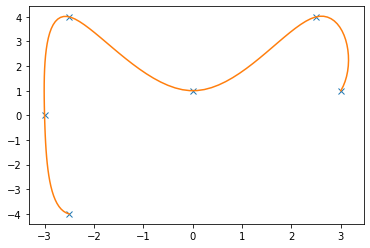

In [107]:
points = control_points
ctrl_pts = parameterizeToBspline(0, points, [[0,0],[0,0],[0,0],[0,0]])
plt.plot(points[:,0], points[:,1],'x')
K = len(points)

out=interpolate.splev(np.linspace(0,K-1,num=100),[list(range(-3,K+3)),[ctrl_pts[:,0],ctrl_pts[:,1]],3])
plt.plot(out[0], out[1])

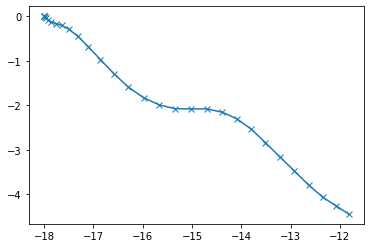